In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier


In [3]:
df = pd.read_csv("PRE_DEPARTURE_STUDENTS_MENTAL_HEALTH_SURVEY_EXTENDED.csv")

print(df.shape)
df.head()


(302, 31)


,Timestamp,1. Age Group,2. Gender,3. Academic Level,Destination Country,5. How often do you feel overwhelmed by your responsibilities during pre departure preparation?,6. How often do you feel nervous or on edge about going abroad?,7. Do you find it difficult to relax when thinking about your upcoming move?,8. How often do you worry about your ability to cope with challenges abroad?,9. How often do you feel low energy or lack motivation due to pre_departure stress?,...,21. How comfortable are you discussing your worries with friends or family?,22. How concerned are you about becoming socially isolated abroad?,23. How confident are you about making new friends abroad?,24. Do you get sufficient sleep (7_8_ hours) during the preparation period?,25. How often do you engage in physical activity or exercise?,"26. Do you use relaxation techniques (prayer, meditation, deep breathing)?","27. How prepared do you feel to live independently abroad (cooking, budgeting, managing tasks)?","28. How confident are you about handling unexpected issues abroad (illness, document problems, emergencies)?",29. How strongly do you believe you can manage homesickness after moving abroad?,30. How stressed are you about leaving your family and friends?
0,2025/12/08 11:05:08 PM GMT+6,23–26,Male,Undergraduate,USA,3.0,3.0,No,4.0,5.0,...,2.0,3.0,2.0,No,1.0,No,3.0,2.0,3.0,4.0
1,2025/12/08 11:38:12 PM GMT+6,23–27,Male,Undergraduate,Cypras,3.0,3.0,Yes,2.0,3.0,...,3.0,3.0,2.0,No,2.0,No,2.0,3.0,3.0,2.0
2,2025/12/08 11:41:23 PM GMT+6,23–28,Male,Undergraduate,Australia,3.0,3.0,Yes,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025/12/08 11:43:46 PM GMT+6,23–29,Male,Undergraduate,Anywhere with a good research program,3.0,1.0,No,1.0,1.0,...,5.0,1.0,5.0,No,4.0,Yes,5.0,5.0,3.0,2.0
4,2025/12/08 11:49:38 PM GMT+6,23–30,Male,Undergraduate,USA,4.0,4.0,Yes,1.0,4.0,...,4.0,3.0,4.0,yes,4.0,Yes,3.0,4.0,4.0,3.0


In [4]:
depression_cols = [
    "5. How often do you feel overwhelmed by your responsibilities during pre departure preparation?",
    "6. How often do you feel nervous or on edge about going abroad?",
    "8. How often do you worry about your ability to cope with challenges abroad?",
    "9. How often do you feel low energy or lack motivation due to pre_departure stress?",
    "11. How anxious are you about visa delays or possible rejection?",
    "12. How often do you overthink potential problems that might happen abroad?",
    "14. How stressed do you feel about adapting to a new cultural and academic environment?",
    "20. How often do you feel pressured by your family expectations?",
    "22. How concerned are you about becoming socially isolated abroad?",
    "24. Do you get sufficient sleep (7_8_ hours) during the preparation period?",
    "30. How stressed are you about leaving your family and friends?"
]


In [5]:
df[depression_cols] = df[depression_cols].apply(
    pd.to_numeric, errors="coerce"
)


In [6]:

sleep_col = "24. Do you get sufficient sleep (7_8_ hours) during the preparation period?"
df[sleep_col] = 6 - df[sleep_col]


In [7]:
for col in depression_cols:
    df[col].fillna(df[col].median(), inplace=True)


C:\Users\Asus\AppData\Local\Temp\ipykernel_1992\2861230106.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [8]:
df["Depression_Score"] = df[depression_cols].mean(axis=1)

df["Depression_Score"].describe()


count    302.000000
mean       3.140397
std        0.706324
min        1.500000
25%        2.525000
50%        3.300000
75%        3.700000
max        4.200000
Name: Depression_Score, dtype: float64

In [9]:
def depression_level(score):
    if score <= 2.0:
        return "No/Minimal"
    elif score <= 3.0:
        return "Mild"
    elif score <= 4.0:
        return "Moderate"
    else:
        return "Severe"

df["Depression_Level"] = df["Depression_Score"].apply(depression_level)

df["Depression_Level"].value_counts()


Depression_Level
Moderate      156
Mild           99
Severe         25
No/Minimal     22
Name: count, dtype: int64

In [10]:
df_model = df.drop(columns=depression_cols + ["Depression_Score"])


In [11]:
df_model = df.drop(columns=depression_cols + ["Depression_Score"])


In [12]:
X = df_model.drop(columns=["Depression_Level"])
y = df_model["Depression_Level"]


In [13]:
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns


In [21]:
from sklearn.impute import SimpleImputer



In [22]:
# Numeric pipeline: impute + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: impute + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [24]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])


In [25]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])


In [26]:
from sklearn.linear_model import LogisticRegression


In [27]:
logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])


In [28]:
logreg_model.fit(X_train, y_train)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['10. How confident do you feel in handling emotional ups and downs during this transition?',
       '13. How confident are you in your English/language communication skills?',
       '15. How satisfied are you with your current...
       '7. Do you find it difficult to relax when thinking about your upcoming move?',
       '16. Do you feel pressure to perform well academically abroad? ',
       '19. Do you feel emotionally supported by your family during the pre departure phase?',
       '26. Do you use relaxation techniques (prayer, meditation, deep breathing)?'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='multinomial',
                                    random_state=42))])

In [29]:
y_pred_lr = logreg_model.predict(X_test)


In [30]:
print("Logistic Regression – Classification Report\n")
print(classification_report(y_test, y_pred_lr))

print("\nConfusion Matrix\n")
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression – Classification Report

              precision    recall  f1-score   support

        Mild       1.00      0.90      0.95        20
    Moderate       0.90      0.88      0.89        32
  No/Minimal       0.75      0.75      0.75         4
      Severe       0.50      0.80      0.62         5

    accuracy                           0.87        61
   macro avg       0.79      0.83      0.80        61
weighted avg       0.89      0.87      0.88        61


Confusion Matrix

[[18  1  1  0]
 [ 0 28  0  4]
 [ 0  1  3  0]
 [ 0  1  0  4]]


In [31]:
from sklearn.metrics import accuracy_score

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)


Logistic Regression Accuracy: 0.8688524590163934


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np


In [33]:
logreg_configs = [
    {
        "name": "L2_C_0.1",
        "params": {"penalty": "l2", "C": 0.1, "solver": "lbfgs"}
    },
    {
        "name": "L2_C_1.0",
        "params": {"penalty": "l2", "C": 1.0, "solver": "lbfgs"}
    },
    {
        "name": "L2_C_5.0",
        "params": {"penalty": "l2", "C": 5.0, "solver": "lbfgs"}
    },
    {
        "name": "L1_C_1.0",
        "params": {"penalty": "l1", "C": 1.0, "solver": "saga"}
    },
    {
        "name": "ElasticNet_C_1.0",
        "params": {
            "penalty": "elasticnet",
            "C": 1.0,
            "solver": "saga",
            "l1_ratio": 0.5
        }
    }
]


In [34]:
results = []

for config in logreg_configs:
    print(f"\n========== Model: {config['name']} ==========")
    
    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            multi_class="multinomial",
            class_weight="balanced",
            max_iter=3000,
            random_state=42,
            **config["params"]
        ))
    ])
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)
    
    print("Accuracy:", round(acc, 3))
    print("Weighted F1:", round(f1, 3))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", cm)
    
    results.append({
        "Model": config["name"],
        "Accuracy": acc,
        "Weighted_F1": f1
    })



========== Model: L2_C_0.1 ==========
Accuracy: 0.836
Weighted F1: 0.847

Classification Report:
              precision    recall  f1-score   support

        Mild       0.94      0.85      0.89        20
    Moderate       0.93      0.78      0.85        32
  No/Minimal       0.80      1.00      0.89         4
      Severe       0.45      1.00      0.62         5

    accuracy                           0.84        61
   macro avg       0.78      0.91      0.81        61
weighted avg       0.89      0.84      0.85        61

Confusion Matrix:
 [[17  2  1  0]
 [ 1 25  0  6]
 [ 0  0  4  0]
 [ 0  0  0  5]]

========== Model: L2_C_1.0 ==========
Accuracy: 0.869
Weighted F1: 0.877

Classification Report:
              precision    recall  f1-score   support

        Mild       1.00      0.90      0.95        20
    Moderate       0.90      0.88      0.89        32
  No/Minimal       0.75      0.75      0.75         4
      Severe       0.50      0.80      0.62         5

    accuracy     

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.

Accuracy: 0.852
Weighted F1: 0.86

Classification Report:
              precision    recall  f1-score   support

        Mild       0.90      0.90      0.90        20
    Moderate       0.96      0.78      0.86        32
  No/Minimal       0.80      1.00      0.89         4
      Severe       0.50      1.00      0.67         5

    accuracy                           0.85        61
   macro avg       0.79      0.92      0.83        61
weighted avg       0.89      0.85      0.86        61

Confusion Matrix:
 [[18  1  1  0]
 [ 2 25  0  5]
 [ 0  0  4  0]
 [ 0  0  0  5]]

========== Model: ElasticNet_C_1.0 ==========
Accuracy: 0.885
Weighted F1: 0.892

Classification Report:
              precision    recall  f1-score   support

        Mild       0.95      0.90      0.92        20
    Moderate       0.96      0.84      0.90        32
  No/Minimal       0.80      1.00      0.89         4
      Severe       0.56      1.00      0.71         5

    accuracy                           0.89      

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [36]:
final_logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        multi_class="multinomial",
        class_weight={
            "No/Minimal": 2.0,
            "Mild": 1.0,
            "Moderate": 1.0,
            "Severe": 2.5
        },
        max_iter=5000,
        random_state=42
    ))
])


In [37]:
final_logreg_model.fit(X_train, y_train)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['10. How confident do you feel in handling emotional ups and downs during this transition?',
       '13. How confident are you in your English/language communication skills?',
       '15. How satisfied are you with your current...
       '16. Do you feel pressure to perform well academically abroad? ',
       '19. Do you feel emotionally supported by your family during the pre departure phase?',
       '26. Do you use relaxation techniques (prayer, meditation, deep breathing)?'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight={'Mild': 1.0, 'Moderate': 1.0,
                                                  'No/Minimal': 2.0,
                                                  'Severe': 2.5},
                                    max_iter=5000, multi_class='multinomial',
                                    random_state=42))])

In [38]:
y_pred_final = final_logreg_model.predict(X_test)


In [39]:
accuracy = accuracy_score(y_test, y_pred_final)
print("Final Logistic Regression Accuracy:", round(accuracy, 4))


Final Logistic Regression Accuracy: 0.8361


In [40]:
print("Final Logistic Regression – Classification Report\n")
print(classification_report(y_test, y_pred_final))


Final Logistic Regression – Classification Report

              precision    recall  f1-score   support

        Mild       1.00      0.90      0.95        20
    Moderate       0.85      0.88      0.86        32
  No/Minimal       0.75      0.75      0.75         4
      Severe       0.33      0.40      0.36         5

    accuracy                           0.84        61
   macro avg       0.73      0.73      0.73        61
weighted avg       0.85      0.84      0.84        61



In [41]:
cm = confusion_matrix(y_test, y_pred_final)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[18  1  1  0]
 [ 0 28  0  4]
 [ 0  1  3  0]
 [ 0  3  0  2]]


In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


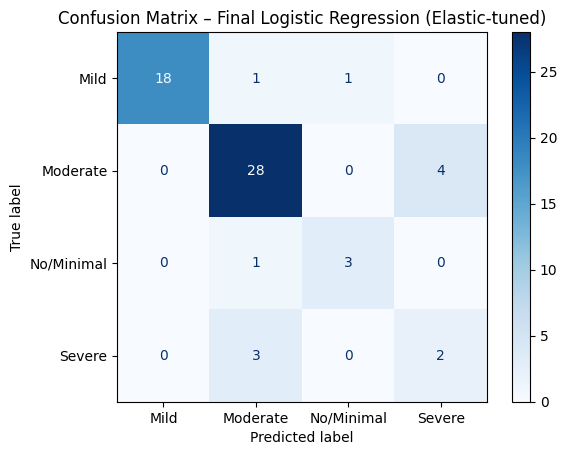

In [43]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_final,
    cmap="Blues"
)
plt.title("Confusion Matrix – Final Logistic Regression (Elastic-tuned)")
plt.show()


In [44]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


ModuleNotFoundError: No module named 'xgboost'